This project explores the best locations for Italian restaurants throughout the city of New York. I will attempt to answer the questions “Where should I open an Italian Restaurant?” and “Where should I stay If I want great Italian food?”

Data:
New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Data related to locations and quality of Italian restaurants will be obtained via the FourSquare API.

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
print('Libraries imported!')

Libraries imported!


In [2]:
conda update -n base -c defaults conda

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.8  |       h06a4308_0         121 KB
    conda-package-handling-1.7.2|   py37h03888b9_0         885 KB
    idna-2.10                  |             py_0          50 KB
    openssl-1.1.1i             |       h27cfd23_0         2.5 MB
    pip-20.3.1                 |   py37h06a4308_0         1.8 MB
    pycosat-0.6.3              |   py37h27cfd23_0          81 KB
    pyopenssl-20.0.0           |     pyhd3eb1b0_1          49 KB
    requests-2.25.0            |     pyhd3eb1b0_0          52 KB
    ruamel_yaml-0.15.87        |   py37h7b6447c_1         245 KB
    setuptools-51.0.0          |   py37h06a4308_2         711 KB
    tqdm-4.54.1                |     pyhd3eb1b0_0          55 KB
    urllib3-1.25.1

In [2]:
import json
# library to handle JSON files
import random # library for random number generation
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
# libraries for displaying images
from IPython.display import Image
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [4]:
!pip install folium

     |████████████████████████████████| 93 kB 3.2 MB/s  eta 0:00:01


In [5]:
import folium

In [6]:
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Import Done!')

Import Done!


In [7]:
!pip install requests
import requests
#print('Ok')

In [8]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: PNSOD11X011AD4MXVIEFY2HUT5AVY5R351VYOYCD3BXK244R
CLIENT_SECRET:A1UR5B0KHP0CEABHBNBMTNVWH2RDOKDJN2VQG3EOAJ1ZSYSP


Functions to be called later in the program

In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Get initial NYC data using the above functions

In [10]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
ny_data.shape 

(306, 4)

Data Analysis:

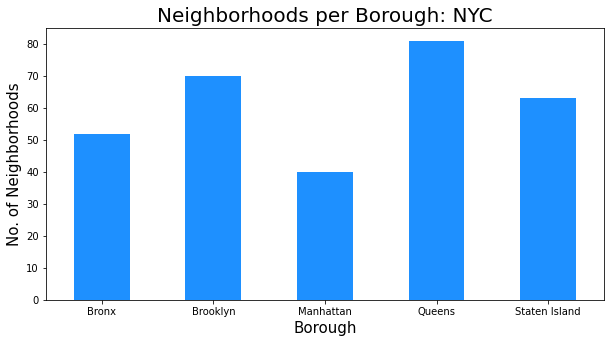

In [12]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Let's analyze further and see how many italian restaurants are there in each neighborhood and burough and graph the results.

In [13]:
# queens has most neighborhoods
# prepare neighborhood list that contains Italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [14]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [15]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv', index_col=[0])
italian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
225,Manhattan,Flatiron,53370455498e18d7e6607a1d,La Pizza & La Pasta
226,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa
227,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
228,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
229,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [16]:
italian_rest_ny.shape


(230, 4)

As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number of Italian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Belmont has the highest number of Italian restaurants in all of NYC and is actually located in the burough of Bronx vice Manhattan.

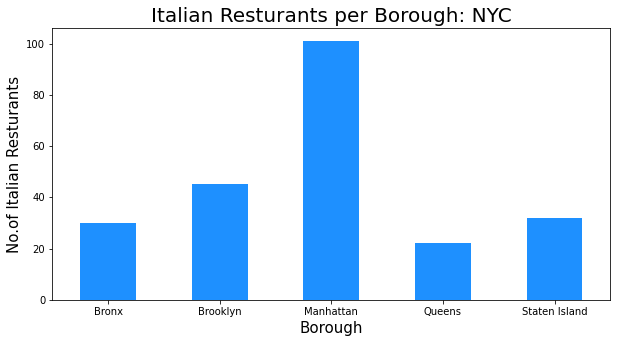

In [17]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

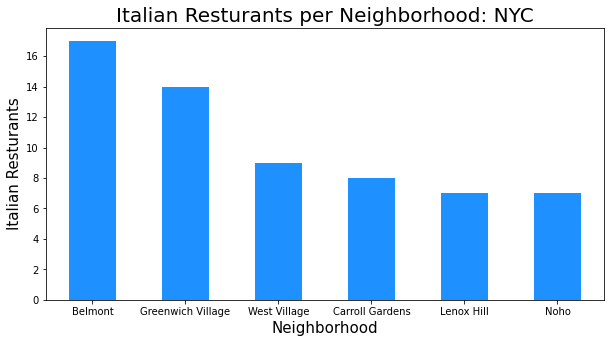

In [18]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [19]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
6,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
7,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
9,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
10,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
11,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
12,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
13,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering
14,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
15,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant


In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()


    

{'meta': {'code': 200, 'requestId': '5fd60a209e3c085277a4b2d2'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

KeyError: 'venue'

In [21]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') # continuing to save data to a .csv as I move through this project


In [22]:
italian_rest_stats_ny.shape


(50, 7)

In [23]:
italian_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [24]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [25]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,36.960000,7.634000,17.100000
std,35.423364,1.373452,13.343576
min,0.000000,0.000000,0.000000
25%,11.250000,7.225000,6.000000
50%,22.500000,7.800000,13.500000
75%,48.250000,8.275000,25.750000
max,147.000000,9.300000,48.000000


In [26]:
# Restaurant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                147
Rating                               9.3
Tips                                  48
Name: 6, dtype: object

In [27]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]


Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                147
Rating                               9.3
Tips                                  48
Name: 6, dtype: object

In [28]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                147
Rating                               9.3
Tips                                  48
Name: 6, dtype: object

In [29]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Bushwick,9.300000
2,Bedford Stuyvesant,8.800000
17,Pelham Gardens,8.700000
20,Woodlawn,8.500000
9,Cobble Hill,8.433333
14,Morris Park,8.400000
8,City Island,8.100000
7,Carroll Gardens,7.975000
3,Belmont,7.923529
12,Gravesend,7.800000


In [47]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,7.817241
1,Brooklyn,7.380952


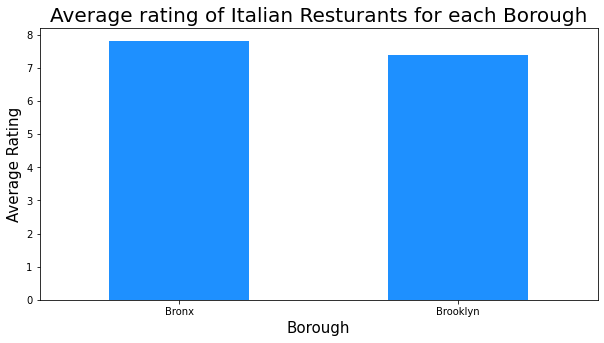

In [31]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [32]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bedford Stuyvesant,8.800000
6,Bushwick,9.300000
8,City Island,8.100000
9,Cobble Hill,8.433333
14,Morris Park,8.400000
17,Pelham Gardens,8.700000
20,Woodlawn,8.500000


In [33]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.800000
1,Brooklyn,Bushwick,40.698116,-73.925258,9.300000
2,Bronx,City Island,40.847247,-73.786488,8.100000
3,Brooklyn,Cobble Hill,40.687920,-73.998561,8.433333
4,Bronx,Morris Park,40.847549,-73.850402,8.400000
5,Bronx,Pelham Gardens,40.862966,-73.841612,8.700000
6,Bronx,Woodlawn,40.898273,-73.867315,8.500000


In [34]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
 
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [35]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [44]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Finally, we will visualize all NYC buroughs based on average Rating.

In [38]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Results / Conclusion:
Bronx and Brooklyn have the best rated Italian restaurants on average. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Italian restaurants. Based on this information, I would state that Manhattan and Queens are the best locations for Italian cuisine in NYC. To have the best shot of success, I would open an Italian restaurants in Queens. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Italian restaurants making competition easier than in other boroughs. Finally, I would go to Belmont in Bronx for the best Italian food based on 147 likes. As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.